<a href="https://colab.research.google.com/github/joaoflauzino/fraud_detection/blob/main/HandsOn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
from google.colab import files
from google.colab import drive
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import numpy as np 
import seaborn as sns 
from imblearn.over_sampling import SMOTE 
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Problema

* Cenário de transações bancárias
* Muitos eventos de fraudes ocorrendo sem ação rápida para trativas

# Objetivo

* Ensinar a máquina para identificar fraude sem a necessidade de intervenção humana

# Leitura da base

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/datasets/FraudDetection.csv')

In [ ]:
df.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [ ]:
df.shape

(6362620, 11)

# Exploração

In [ ]:
# Definir numero casas decimais
pd.set_option('float_format', '{:.2f}'.format)

In [ ]:
# Estatisticas básicas
df.describe()

# 25% dos dados de transações estão abaixo de 13 mil
# 50% dos dados estão abaixo de 74 mil
# 75% dos dados estão abaixo 208 mil

# Média de 179.861 reais em transações
# Desvio padrão de 603 mil em transações
# Altos indicios de outlier

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [ ]:
# Verificar valores nulos
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
# Group by por flag
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
df_new = df.copy()

In [ ]:
df_new.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0


In [ ]:
# Em que casos conseguimos identificar fraude? Quando isso acontece?
df_new['nameDest'].head()

0    M1979787155
1    M2044282225
2     C553264065
3      C38997010
4    M1230701703
Name: nameDest, dtype: object

In [ ]:
df_new['type1'] = ''

df_new.loc[ df_new.nameOrig.str.contains('C') & df_new.nameDest.str.contains('C'), "type1"] = "CC" 
df_new.loc[ df_new.nameOrig.str.contains('C') & df_new.nameDest.str.contains('M'), "type1"] = "CM"
df_new.loc[ df_new.nameOrig.str.contains('M') & df_new.nameDest.str.contains('C'), "type1"] = "MC"
df_new.loc[ df_new.nameOrig.str.contains('M') & df_new.nameDest.str.contains('M'), "type1"] = "MM"

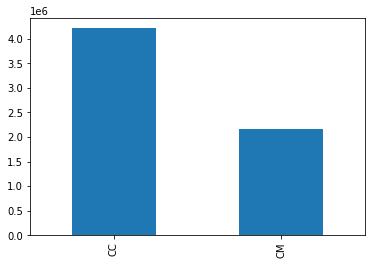

In [ ]:
df_new['type1'].value_counts().plot.bar()

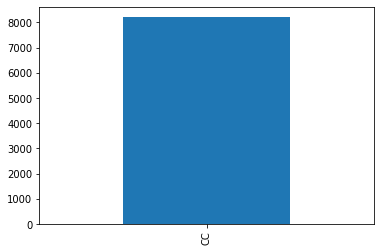

In [ ]:
df_new[ df_new['isFraud'] == 1]['type1'].value_counts().plot.bar()

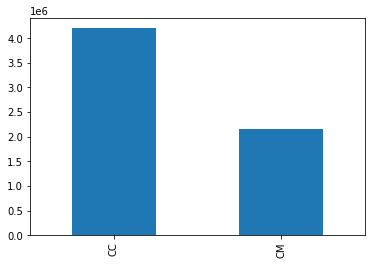

In [ ]:
df_new[ df_new['isFraud'] == 0]['type1'].value_counts().plot.bar()

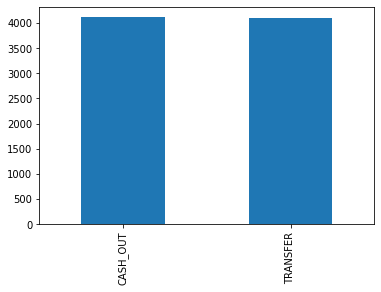

In [ ]:
# Em quais tipos de transações ocorrem fraudes?
df_new[df_new['isFraud'] == 1]['type'].value_counts().plot.bar()

In [ ]:
# Em quais tipos de transação não ocorre fraude
df_new[df_new['isFraud'] == 0]['type'].value_counts()

CASH_OUT    2233384
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     528812
DEBIT         41432
Name: type, dtype: int64

In [ ]:
df_new['isFlaggedFraud'].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [ ]:
# Será que o cara que realiza fraude sempre utiliza a mesma conta?
max(df_new[ df_new['isFraud'] == 1     ]['nameOrig'].value_counts())

1

In [ ]:
max(df_new[ df_new['isFraud'] == 1     ]['nameDest'].value_counts())

2

In [ ]:
# Qual o valor de balanço que mais repete quando eu tenho fraude
df_new[ df_new['isFraud'] == 1  ]['oldbalanceDest'].mode()

0   0.00
dtype: float64

In [ ]:
df_new[ df_new['isFraud'] == 1  ]['oldbalanceDest'].mode()

0   0.00
dtype: float64

In [ ]:
df_new[ df['isFraud'] == 1].corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.00,0.05,0.06,0.06,0.02,0.03,nan,0.03
amount,0.05,1.00,0.86,0.34,-0.01,0.30,nan,0.06
oldbalanceOrg,0.06,0.86,1.00,0.77,-0.01,0.19,nan,0.08
newbalanceOrig,0.06,0.34,0.77,1.00,-0.02,-0.03,nan,0.17
oldbalanceDest,0.02,-0.01,-0.01,-0.02,1.00,0.88,nan,-0.01
newbalanceDest,0.03,0.30,0.19,-0.03,0.88,1.00,nan,-0.01
isFraud,nan,nan,nan,nan,nan,nan,nan,nan
isFlaggedFraud,0.03,0.06,0.08,0.17,-0.01,-0.01,nan,1.00


# Preparar os dados para rodar modelos

In [ ]:
df_new['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df_new['type'].unique())
df_new['type'] = le.transform(df_new['type'])

In [ ]:
df_new['type'].unique()

array([3, 4, 1, 2, 0])

In [ ]:
df_new = df_new.drop(['nameOrig', 'nameDest', 'type1', 'step'], axis = 1)

In [ ]:
df_new.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,3,9839.64,170136.00,160296.36,0.00,0.00,0,0
1,3,1864.28,21249.00,19384.72,0.00,0.00,0,0
2,4,181.00,181.00,0.00,0.00,0.00,1,0
3,1,181.00,181.00,0.00,21182.00,0.00,1,0
4,3,11668.14,41554.00,29885.86,0.00,0.00,0,0


# Variável dependente e independente

In [ ]:
[i for i in df_new.columns if i != 'isFraud' and i != 'isFlaggedFraud']


['type',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

In [ ]:
# Variaveis independentes
X = df_new[ [i for i in df_new.columns if i != 'isFraud' and i != 'isFlaggedFraud'] ]
X.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,3,9839.64,170136.00,160296.36,0.00,0.00
1,3,1864.28,21249.00,19384.72,0.00,0.00
2,4,181.00,181.00,0.00,0.00,0.00
3,1,181.00,181.00,0.00,21182.00,0.00
4,3,11668.14,41554.00,29885.86,0.00,0.00


In [ ]:
# Variável dependente
y = df_new['isFraud']
y.head()

0    0
1    0
2    1
3    1
4    0
Name: isFraud, dtype: int64

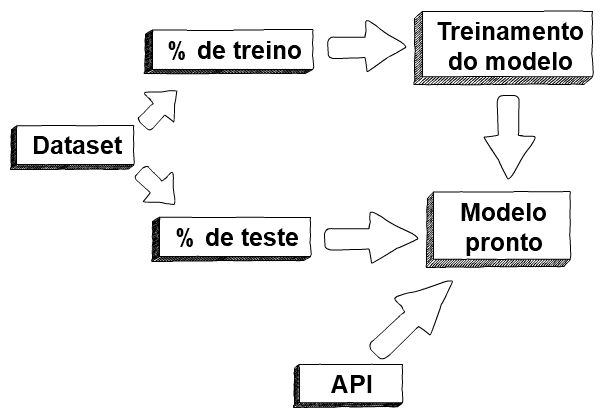

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [ ]:
X_train.shape[0] / df_new.shape[0]

0.7

In [ ]:
X_test.shape[0] / df_new.shape[0]

0.3

# Regressão Logística

In [ ]:
rg = LogisticRegression(random_state=42, class_weight='balanced')

In [ ]:
%%time
rg.fit(X_train, y_train)

CPU times: user 32.2 s, sys: 5.75 s, total: 38 s
Wall time: 27.9 s


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
X_test.head()

,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
5602983,1,106137.63,0.00,0.00,2688399.83,2794537.46
5590587,0,33587.03,5473617.21,5507204.24,164819.19,131232.17
5565256,1,129547.02,0.00,0.00,373650.30,503197.32
1368433,1,165680.80,42819.00,0.00,10993.48,127203.05
5173925,4,484078.56,0.00,0.00,1362747.64,1846826.20


In [ ]:
X_test.loc[5565256].tolist()

[1.0, 129547.02, 0.0, 0.0, 373650.3, 503197.32]

In [ ]:
rg.predict([X_test.loc[5565256].tolist()])

array([0])

In [ ]:
df.loc[5565256]

step                     393
type                CASH_OUT
amount             129547.02
nameOrig          C359042469
oldbalanceOrg           0.00
newbalanceOrig          0.00
nameDest          C547923441
oldbalanceDest     373650.30
newbalanceDest     503197.32
isFraud                    0
isFlaggedFraud             0
Name: 5565256, dtype: object

In [ ]:
predictions_rg = rg.predict(X_test)

In [ ]:
# Criando a matriz de confusão
data_rg = {'y_Actual':  y_test,
        'y_Predicted': predictions_rg}

df_rg = pd.DataFrame(data_rg, columns=['y_Actual','y_Predicted'])
df_rg.head()
confusion_matrix_rg = pd.crosstab(df_rg['y_Actual'], df_rg['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

In [ ]:
y_test.value_counts()

0    1906296
1       2490
Name: isFraud, dtype: int64

In [ ]:
confusion_matrix_rg

Predicted,0,1
Actual,,
0,1250504,655792
1,46,2444


In [ ]:
print('Porcentagem de acerto dos casos não fraude: ', 1903078 / (1903078 + 3218))
print('Porcentagem de acerto dos casos como fraude: ', 1987 / (503 + 1987))

Porcentagem de acerto dos casos não fraude:  0.9983119095880179
Porcentagem de acerto dos casos como fraude:  0.797991967871486


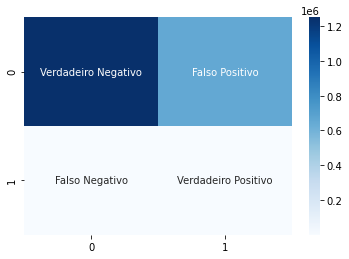

In [ ]:
cf_matrix = confusion_matrix(y_test, predictions_rg)
labels = ['Verdadeiro Negativo','Falso Positivo','Falso Negativo','Verdadeiro Positivo']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

In [ ]:
print("Acc: ", accuracy_score(y_test, predictions_rg))
print('Precisão: ', precision_score(y_test, predictions_rg)) # Positivos verdadeiros sobre total de positivos. Quanto menor, mais falso positivos contém na predição.
print('Recall: ', recall_score(y_test, predictions_rg)) #Número de positivos verdadeiros divididos pelo número de valores positivos nos dados de teste. Quanto menor, mais falso negativos contém na predição
print('f1_score: ', f1_score(y_test, predictions_rg))

Acc:  0.9980505934138243
Precisão:  0.38174831892411143
Recall:  0.797991967871486
f1_score:  0.5164392462638077


In [ ]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [ ]:
oversamples = SMOTE()
X_new, y_new = oversamples.fit_sample(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
from collections import Counter
Counter(y_new)

Counter({0: 6354407, 1: 6354407})

In [ ]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(X_new, y_new, test_size=0.30)

In [ ]:
%%time
#Aplicando Regressão Logística na nova distribuição de classes
rg_new = LogisticRegression(random_state=42)
rg_new.fit(X_train_n, y_train_n)
predictions_rg_new = rg_new.predict(X_test_n)

CPU times: user 47.2 s, sys: 5.26 s, total: 52.5 s
Wall time: 40.8 s


In [ ]:
# Matriz de confusão
data_rg_new = {'y_Actual': y_test_n,
        'y_Predicted': predictions_rg_new}

df_rg_new = pd.DataFrame(data_rg_new, columns=['y_Actual','y_Predicted'])
confusion_matrix_rg_new = pd.crosstab(df_rg_new['y_Actual'], df_rg_new['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

In [ ]:
confusion_matrix_rg_new

Predicted,0,1
Actual,,
0,1324041,582905
1,33463,1872236


In [ ]:
print('Porcentagem de acerto para 0: ', 1324041 / (1324041 + 582905))
print('Porcentagem de acerto para 1: ', 1872236 / (33463 + 1872236))

Porcentagem de acerto para 0:  0.6943253768066846
Porcentagem de acerto para 1:  0.9824405638036227


In [ ]:
# Avaliando métricas do modelo
print("Acc: ", accuracy_score(y_test_n, predictions_rg_new))
print('Precisão: ', precision_score(y_test_n, predictions_rg_new)) # Positivos verdadeiros sobre total de positivos. Quanto menor, mais falso positivos contém na predição.
print('Recall', recall_score(y_test_n, predictions_rg_new)) # Número de positivos verdadeiros divididos pelo número de valores positivos nos dados d teste. Quanto menor, mais falso negativos contém na predição
print('f1_score: ', f1_score(y_test_n, predictions_rg_new))
print('AUC: ', roc_auc_score(y_test_n, predictions_rg_new))

Acc:  0.8383358534560653
Precisão:  0.7625777908478576
Recall 0.9824405638036227
f1_score:  0.8586584236064612
AUC:  0.8383829703051536


# Aplicando Árvore de Decisão

In [ ]:
# Aplicar Árvore de Decisão
dt = DecisionTreeClassifier(random_state=42)

In [ ]:
%%time
dt.fit(X_train_n, y_train_n)

CPU times: user 2min 4s, sys: 178 ms, total: 2min 4s
Wall time: 2min 4s


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

In [ ]:
predictions = dt.predict(X_test_n)

In [ ]:
# Matriz de confusão
data_dt = {'y_Actual':    y_test_n,
        'y_Predicted': predictions}

df_dt = pd.DataFrame(data_dt, columns=['y_Actual','y_Predicted'])
confusion_matrix_dt = pd.crosstab(df_dt['y_Actual'], df_dt['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

In [ ]:
confusion_matrix_dt

Predicted,0,1
Actual,,
0,1905909,1037
1,526,1905173


In [ ]:
print('Porcentagem de acerto para 0: ', 1905909 / (1905909 + 1037))
print('Porcentagem de acerto para 1: ', 1905173 / (1905173 + 526))

Porcentagem de acerto para 0:  0.9994561985499327
Porcentagem de acerto para 1:  0.99972398579209


In [ ]:
# Métricas para avaliar o modelo
print("Acc: ", accuracy_score(y_test_n, predictions))
print('Precisão: ', precision_score(y_test_n, predictions))  # Positivos verdadeiros sobre total de positivos. Quanto menor, mais falso positivos contém na predição.
print('Recall', recall_score(y_test_n, predictions)) # Número de positivos verdadeiros divididos pelo número de valores positivos nos dados d teste. Quanto menor, mais falso negativos contém na predição
print('f1_score: ', f1_score(y_test_n, predictions))
print('AUC: ', roc_auc_score(y_test_n, predictions))

Acc:  0.9995900483784879
Precisão:  0.9994559885846785
Recall 0.99972398579209
f1_score:  0.9995899692253934
AUC:  0.9995900921710114
